# Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Function

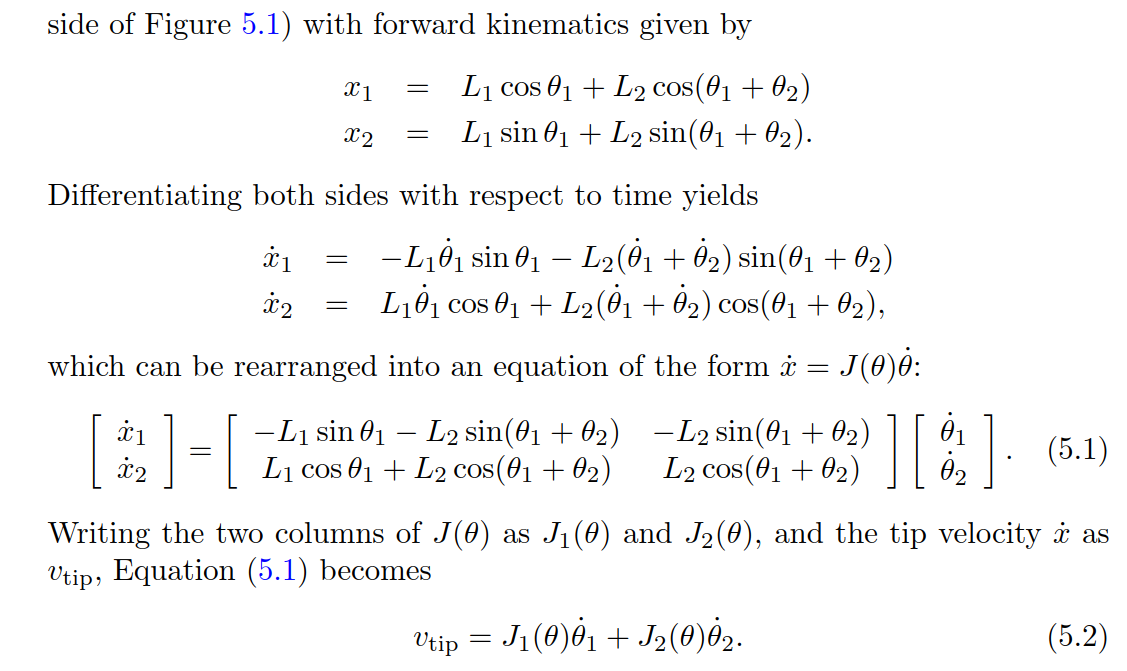</td>

In [2]:
def plot_arm(theta1, theta2, *args, **kwargs):
    shoulder = np.array([0, 0])
    elbow = shoulder + np.array([l1 * np.cos(theta1), l1 * np.sin(theta1)])
    wrist = elbow + np.array([l2 * np.cos(theta1 + theta2), l2 * np.sin(theta1 + theta2)])

    plt.plot([shoulder[0], elbow[0]], [shoulder[1], elbow[1]], 'k-')
    plt.plot([elbow[0], wrist[0]], [elbow[1], wrist[1]], 'k-')

    plt.plot(shoulder[0], shoulder[1], 'ro')
    plt.plot(elbow[0], elbow[1], 'ro')
    plt.plot(wrist[0], wrist[1], 'ro')
    
    
    title = kwargs.get('title', None)
    plt.annotate("X pos = "+str(wrist[0]), xy=(0, 1.8+2), xycoords="data",va="center", ha="center")
    plt.annotate("Y pos = "+str(wrist[1]), xy=(0, 1.5+2), xycoords="data",va="center", ha="center")
    
    circle1 = plt.Circle((0, 0), l1+l2,alpha=0.5, edgecolor='none')
    plt.gca().add_patch(circle1)
    plt.title(title)
    
    plt.xlim(-3, 3)
    plt.ylim(-2, 4)

    plt.show()

In [3]:
# Forward Kinematic
# x_1 is endeffector pose x , x_2 is endeffector pose y
def fk(theta1,theta2):
    x_1 = l1*np.cos(theta1) + l2*np.cos(theta1+theta2)
    x_2 = l1*np.sin(theta1) + l2*np.sin(theta1+theta2)
    return x_1,x_2

In [4]:
# check if the matrix is square
def is_square(J):
    # if the row and column is equal each other that the mat is square
    # J[1,:] = len of column
    # J[:,1] = len of row
    if len(J[1,:]) == len(J[:,1]):
        return True
    else:
        return False

In [5]:
# calcualte Velocity at the tip
def vtip(J1,J2,theta_dot1,theta_dot2):
    return J1*theta_dot1 + J2*theta_dot2

In [6]:
# Jacobian
def jacobian_mat(theta1,theta2):
    J = np.array([[-l1*np.sin(theta1)-l2*np.sin(theta1+theta2) , -l2*np.sin(theta1+theta2)],
                   [l1*np.cos(theta1)+l2*np.cos(theta1+theta2) , l2*np.cos(theta1+theta2)]])
    return J

In [7]:
def plot_arm_history(theta_history):
    for i in range(np.shape(theta_history)[1]-1):
        plot_arm(theta_history[0,i],theta_history[1,i])

# Input

In [8]:
l1 = 1
l2 = 1
theta1 = np.pi/4
theta2 = np.pi/4
x_1 , x_2 = fk(theta1,theta2)
print("x_1 is : %f, x_2 is : %f"%(x_1,x_2))

x_1 is : 0.707107, x_2 is : 1.707107


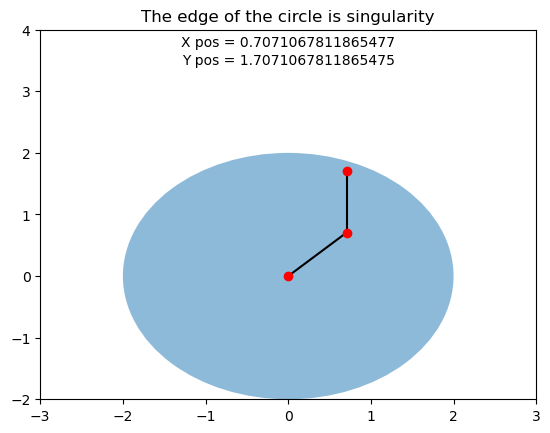

In [9]:
plot_arm(theta1,theta2,title='The edge of the circle is singularity')

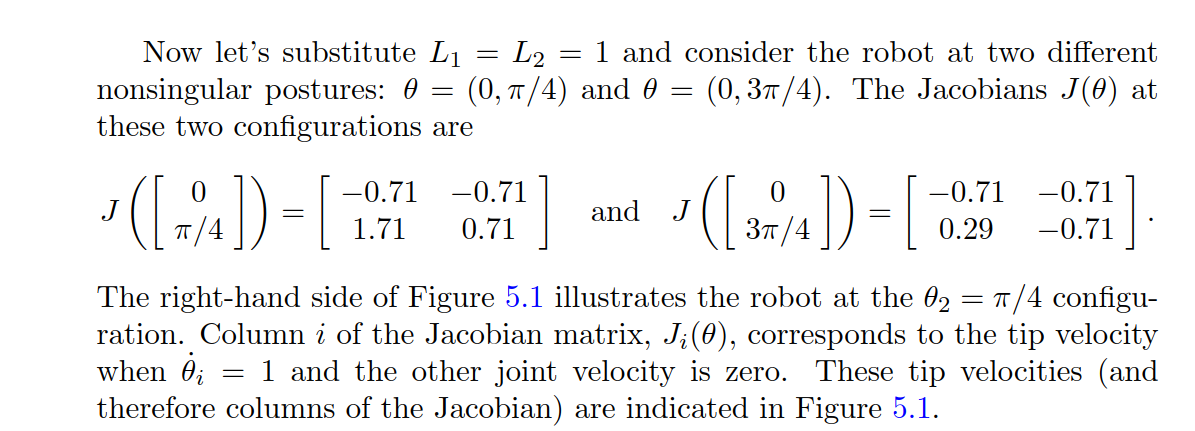</td>

In [10]:
J = jacobian_mat(theta1,theta2)

# Jacobian Each theta
J1 = np.array([[-l1*np.sin(theta1)-l2*np.sin(theta1+theta2)],
               [l1*np.cos(theta1)+l2*np.cos(theta1+theta2)]])

J2 = np.array([[-l2*np.sin(theta1+theta2)],
               [l2*np.cos(theta1+theta2)]])

print(J1)
print(J2)

[[-1.70710678]
 [ 0.70710678]]
[[-1.000000e+00]
 [ 6.123234e-17]]


In [11]:
is_square(J)

True

In [12]:
# Determine the J determenant
np.linalg.det(J)
# the det(J) is not 0 , and J is square -> invertible
# the det(J) is 0 or J is square -> uninvertible -> singular matrix ( even the numpy, tell you it is singular matrix)

0.7071067811865476

In [13]:
inv_J = np.linalg.inv(J) # simple inverse
pinv_J = np.linalg.pinv(J) # using pseudo inverse
print(inv_J)
print(pinv_J)

[[ 1.30070718e-16  1.41421356e+00]
 [-1.00000000e+00 -2.41421356e+00]]
[[ 1.92490079e-16  1.41421356e+00]
 [-1.00000000e+00 -2.41421356e+00]]


In [14]:
# calcualte vtip
v_tip = vtip(J1,J2,0.2,0.2)
print(v_tip)

[[-0.54142136]
 [ 0.14142136]]


# Normal Inverse Jacobian IK Newton Raspson

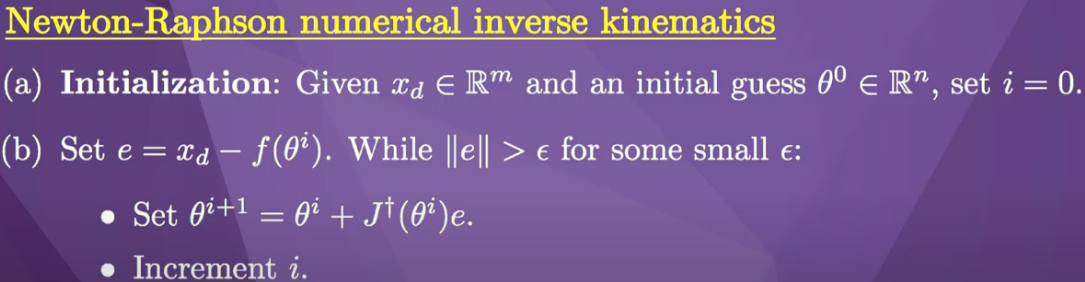

In [15]:
def ik_jac_normal_inv(theta,x_desired):
    theta_history = theta
    forwardk = fk(theta[0,0],theta[1,0])
    e = x_desired - np.array([[forwardk[0]],[forwardk[1]]])
    max_iter = 100 # for when it can't reach desired pose
    i = 0

    while np.linalg.norm(e) > 0.001 and i < max_iter:      # norm = sqrt(x^2 + y^2)

        forwardk = fk(theta[0,0],theta[1,0])
        e = x_desired - np.array([[forwardk[0]],[forwardk[1]]])
        Jac = jacobian_mat(theta[0,0],theta[1,0])
        theta = theta + np.linalg.inv(Jac).dot(e)
        print(theta)
        theta_history = np.append(theta_history, theta, axis=1)
        i+=1
    return theta,theta_history

# Setting target positions closer (with Clamp Magnitude)

In [16]:
def clampMag(w,d):
    if np.linalg.norm(w)<=d:
        return w
    else:
        return d*(w/np.linalg.norm(w))

In [17]:
# test
t = np.array([[0.5],[0.5]])
Dmax = 0.5
e = clampMag(t,Dmax)
print(e)
# https://stackoverflow.com/questions/55502515/how-to-clamp-a-vector-within-some-magnitude
# ([0.5, 0.5], 1) = [0.5, 0.5] answer
# ([0.5, 0.5], 0.5) = [0.35355339059327373, 0.35355339059327373] answer

[[0.35355339]
 [0.35355339]]


In [18]:
def ik_jac_clampMag(theta,x_desired,Dmax):
    theta_history = theta
    forwardk = fk(theta[0,0],theta[1,0])
    e = x_desired - np.array([[forwardk[0]],[forwardk[1]]])
    e = clampMag(e,Dmax)
    max_iter = 100 # for when it can't reach desired pose
    i = 0

    while np.linalg.norm(e) > 0.001 and i < max_iter:      # norm = sqrt(x^2 + y^2)

        forwardk = fk(theta[0,0],theta[1,0])
        e = x_desired - np.array([[forwardk[0]],[forwardk[1]]])
        e = clampMag(e,Dmax)
        Jac = jacobian_mat(theta[0,0],theta[1,0])
        theta = theta + np.linalg.inv(Jac).dot(e)
        print(theta)
        theta_history = np.append(theta_history, theta, axis=1)
        i+=1
    return theta,theta_history

# Jacobian Transpose Method

In [19]:
def ik_jac_transpose(theta,x_desired,alpha):
    theta_history = theta
    forwardk = fk(theta[0,0],theta[1,0])
    e = x_desired - np.array([[forwardk[0]],[forwardk[1]]])
    max_iter = 100 # for when it can't reach desired pose
    i = 0

    while np.linalg.norm(e) > 0.001 and i < max_iter:      # norm = sqrt(x^2 + y^2)

        forwardk = fk(theta[0,0],theta[1,0])
        e = x_desired - np.array([[forwardk[0]],[forwardk[1]]])
        Jac = jacobian_mat(theta[0,0],theta[1,0])
        theta = theta + alpha*np.transpose(Jac).dot(e)
        print(theta)
        theta_history = np.append(theta_history, theta, axis=1)
        i+=1
    return theta,theta_history

In [20]:
def cal_alpha(error,Jac):
    pass

# Pseudoinverse Method

In [21]:
def ik_jac_pseudo_inv(theta,x_desired):
    theta_history = theta
    forwardk = fk(theta[0,0],theta[1,0])
    e = x_desired - np.array([[forwardk[0]],[forwardk[1]]])
    max_iter = 100 # for when it can't reach desired pose
    i = 0

    while np.linalg.norm(e) > 0.001 and i < max_iter:      # norm = sqrt(x^2 + y^2)

        forwardk = fk(theta[0,0],theta[1,0])
        e = x_desired - np.array([[forwardk[0]],[forwardk[1]]])
        Jac = jacobian_mat(theta[0,0],theta[1,0])
        theta = theta + np.linalg.pinv(Jac).dot(e)
        print(theta)
        theta_history = np.append(theta_history, theta, axis=1)
        i+=1
    return theta,theta_history

# Damped Least Square

In [22]:
def ik_damped_LS(theta,x_desired,damp_cte):
    theta_history = theta
    forwardk = fk(theta[0,0],theta[1,0])
    e = x_desired - np.array([[forwardk[0]],[forwardk[1]]])
    max_iter = 100 # for when it can't reach desired pose
    i = 0

    while np.linalg.norm(e) > 0.001 and i < max_iter:      # norm = sqrt(x^2 + y^2)

        forwardk = fk(theta[0,0],theta[1,0])
        e = x_desired - np.array([[forwardk[0]],[forwardk[1]]])
        Jac = jacobian_mat(theta[0,0],theta[1,0])
        delta_theta = np.transpose(Jac) @ np.linalg.inv(Jac@np.transpose(Jac) + np.identity(2)*(damp_cte**2)) @ e
        theta = theta + delta_theta
        print(theta)
        theta_history = np.append(theta_history, theta, axis=1)
        i+=1
    return theta,theta_history

# Damped Least Square Prime (DLS with ClampMag)

In [43]:
def ik_damped_LSP(theta,x_desired,damp_cte,Dmax):
    theta_history = theta
    forwardk = fk(theta[0,0],theta[1,0])
    e = x_desired - np.array([[forwardk[0]],[forwardk[1]]])
    e = clampMag(e,Dmax)
    max_iter = 100 # for when it can't reach desired pose
    i = 0

    while np.linalg.norm(e) > 0.001 and i < max_iter:      # norm = sqrt(x^2 + y^2)

        forwardk = fk(theta[0,0],theta[1,0])
        e = x_desired - np.array([[forwardk[0]],[forwardk[1]]])
        e = clampMag(e,Dmax)
        Jac = jacobian_mat(theta[0,0],theta[1,0])
        delta_theta = np.transpose(Jac) @ np.linalg.inv(Jac@np.transpose(Jac) + np.identity(2)*(damp_cte**2)) @ e
        theta = theta + delta_theta
        print(theta)
        theta_history = np.append(theta_history, theta, axis=1)
        i+=1
    return theta,theta_history

# Selectivly Damped Least Square

In [63]:
# ClampMaxAbs(w, d) is deﬁned just like ClampMag, but using the 1-norm instead of the Euclidean norm.
# (the 1-norm of w is the maximum of the absolute values of the components of w)
def clampMagAbs(w,d): 
    if abs(w).max()<=d:
        return w
    else:
        return d*(w/abs(w).max())

In [43]:
def ik_SDLS(theta,x_desired):
    theta_history = theta
    forwardk = fk(theta[0,0],theta[1,0])
    
    gamma_max = np.pi/4 # user tuning
    
    e = x_desired - np.array([[forwardk[0]],[forwardk[1]]])
    e = clampMag(e,Dmax)
    max_iter = 100 # for when it can't reach desired pose
    i = 0

    while np.linalg.norm(e) > 0.001 and i < max_iter:      # norm = sqrt(x^2 + y^2)

        forwardk = fk(theta[0,0],theta[1,0])
        e = x_desired - np.array([[forwardk[0]],[forwardk[1]]])
        e = clampMag(e,Dmax)
        Jac = jacobian_mat(theta[0,0],theta[1,0])
        delta_theta = np.transpose(Jac) @ np.linalg.inv(Jac@np.transpose(Jac) + np.identity(2)*(damp_cte**2)) @ e
        theta = theta + delta_theta
        print(theta)
        theta_history = np.append(theta_history, theta, axis=1)
        i+=1
    return theta,theta_history

# Apply

## Case Desired pose is in the task space 

In [50]:
theta = np.array([[0],[0]]) # vector 2x1
x_desired = np.array([[1],[0.5]]) # vector 2x1

## Case Desired pose is outside of task space

In [54]:
theta = np.array([[0],[0]]) # vector 2x1
x_desired = np.array([[0],[2.5]]) # vector 2x1

## Calculate and Plot

In [55]:
# theta,theta_history = ik_damped_LS(theta,x_desired,0.5)        # damped Least Square
# theta,theta_history = ik_damped_LSP(theta,x_desired,0.5,0.5)   # damped Least Square with clampMag
theta,theta_history = ik_jac_transpose(theta,x_desired,0.5)      # Jac transpose

[[2.5 ]
 [1.25]]
[[0.47287128]
 [0.69879311]]
[[2.07147491]
 [1.5062135 ]]
[[0.33843906]
 [0.87216145]]
[[1.95810351]
 [1.69559377]]
[[0.39633904]
 [1.10206128]]
[[1.6398556 ]
 [1.63854749]]
[[0.31528006]
 [0.89908032]]
[[1.93983755]
 [1.72662829]]
[[0.40720147]
 [1.1388353 ]]
[[1.58593869]
 [1.62385484]]
[[0.31991743]
 [0.87605718]]
[[1.96412745]
 [1.71780083]]
[[0.41312325]
 [1.14048787]]
[[1.57944294]
 [1.61638688]]
[[0.3204729 ]
 [0.86770544]]
[[1.97351912]
 [1.71581714]]
[[0.416486  ]
 [1.14344142]]
[[1.57321708]
 [1.6120599 ]]
[[0.32138365]
 [0.8628268 ]]
[[1.97866829]
 [1.71395428]]
[[0.41786516]
 [1.1438573 ]]
[[1.57165404]
 [1.61031824]]
[[0.32160083]
 [0.86094672]]
[[1.98072426]
 [1.71338681]]
[[0.41853837]
 [1.14430555]]
[[1.57058372]
 [1.60945748]]
[[0.3217733 ]
 [0.86000767]]
[[1.98171534]
 [1.71302836]]
[[0.41880874]
 [1.1443878 ]]
[[1.57027594]
 [1.60911598]]
[[0.32181931]
 [0.85964181]]
[[1.98211308]
 [1.71291304]]
[[0.41893624]
 [1.14446616]]
[[1.5700813 ]
 [1.60895323

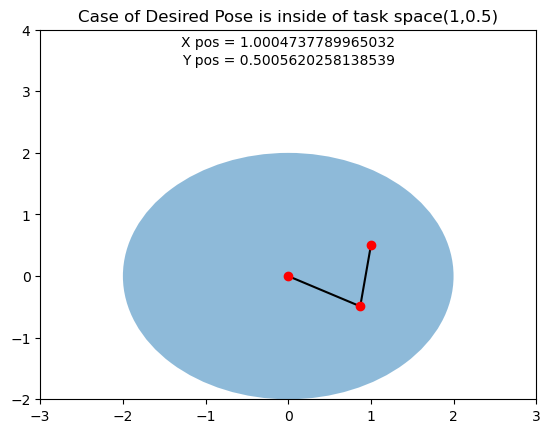

In [52]:
plot_arm(theta[0,0],theta[1,0],title="Case of Desired Pose is inside of task space(1,0.5)")

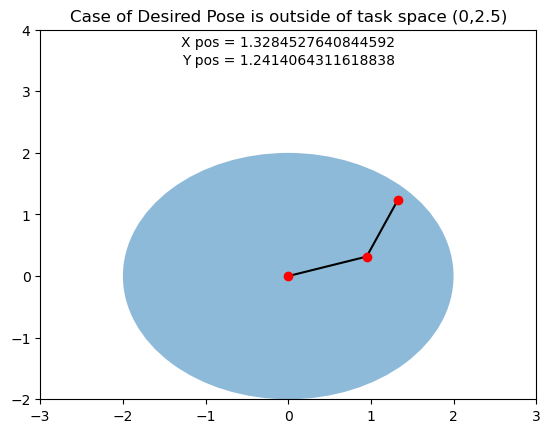

In [56]:
plot_arm(theta[0,0],theta[1,0],title="Case of Desired Pose is outside of task space (0,2.5)")

In [62]:
abs(np.array([[2],[-6]])).max()

6

In [70]:
clampMagAbs(np.array([[2],[-6]]),5)

array([[ 1.66666667],
       [-5.        ]])